# GE interneuron lineage Figure

In [1]:
import shoji
import numpy as np
import loompy
import re
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import cytograph.visualization as cgplot
import matplotlib
matplotlib.rc('pdf', fonttype=42)


/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-07 14:10:24.158217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /proj/user/miri/anaconda3/lib/:/usr/local/lib:/usr/lib:/usr/local/lib64:/usr/lib64
2022-11-07 14:10:24.158252: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
db = shoji.connect()

ws = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium12wk"]
#ws = db["builds"]["sten"]["humandev20220523"]["Subpallium8wk"]


In [3]:
cd '/proj/user/miri/human_development/final_figures/subpallium'

/proj/user/miri/human_development/final_figures/subpallium


In [5]:
list = ws.SelectedFeatures[:]
markers = ['NKX2-1','ASCL1','SOX6','LHX6','HES5','GAD2','ADGRV1','CENPF','UBE2C','NXPH1','NR2F2','DLX2','NFIX','PROX1','CDH7','EMX1','PVALB','ID2','TSHZ1','NR2F2','PDYN','PENK','SIX3','KPNA2','FOXP1','EBF1','HES1','NHLH1','SOX14','GAD1','MKI67','HOPX',
           'FOXD1','FOXP1','EBF1','NXPH1','FAM107A','SLC1A3','HMX3','EN1','CDH7','ID2','TOX3','SST','ERBB4','CXCR4','LHX8','ROBO3','CPE','CRABP1','ANGPT2','ETV1','ST18','CALB2','CCK','RELN','VIP','CHODL','FOXG1','OTP','SIM1','SIM2','CCNO']
for i in markers:
    ind = np.where(ws.Gene[:]==i)[0]

    list[ind] = True
    
ws['SelectedFeatures'] = shoji.Tensor('bool', ('genes',) , inits=list)

In [6]:
adata = ws.create_anndata(only_selected=True,obsm=['Factors','Embedding'])

/home/miri/src/shoji/shoji/workspace.py:515: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata =sc.AnnData(df)


In [7]:
adata.var_names = adata.var['Gene']


In [22]:

#View of cells that express DLX2 and not EMX1
cells1 = np.bitwise_and(ws.Expression[:,ws['Gene']=='EMX1']==0,ws.Expression[:,ws['Gene']=='DLX2']>0)
view1 = ws.cells[cells1.T[0]]
#Filter out EMX1 expressing cells 
cells = ws.Expression[:,ws['Gene']=='EMX1']==0
view = ws.cells[cells.T[0]]
ind = adata.X[:,adata.var_names=='EMX1']==0
adata = adata[ind,:].copy()


In [9]:
adata.obsm['X_umap']= adata.obsm['Embedding']

In [12]:
def plot_IN_lineages(adata,name):
    xy = adata.obsm['Embedding'][:]
    #xy= adata.obsm['X_umap']
    sc.tl.score_genes(adata,MGE_genes,score_name='MGE_score')
    sc.tl.score_genes(adata,CGE_genes,score_name='CGE_score')
    sc.tl.score_genes(adata,LGE_genes,score_name='LGE_score')
    adata.obs['MGE'] = (adata.obs['MGE_score']>0.05).astype(int)
    adata.obs['CGE'] = (adata.obs['CGE_score']>0.05).astype(int)
    adata.obs['LGE'] = (adata.obs['LGE_score']>0.05).astype(int)
    adata.obs['GE'] = ''
    
    adata.obs.loc[adata.obs['MGE'].astype(bool),'GE'] = 'MGE'
    adata.obs.loc[adata.obs['CGE'].astype(bool),'GE'] = 'CGE'
    adata.obs.loc[adata.obs['LGE'].astype(bool),'GE'] = 'LGE'
    labels = np.array(adata.obs['GE'])
    plt.figure(None, ((np.abs(np.max(xy[:,0])-np.min(xy[:,0]))/5), (np.abs(np.max(xy[:,1])-np.min(xy[:,1]))/5)))
    cgplot.scatterc(
    xy,colors="GE",c = labels, legend="upper right",rasterized=True)
    plt.axis('off')
    plt.legend('',frameon=False)
    plt.savefig(name+'.pdf',dpi= 200)


In [29]:
def plot_markers(view,markers,height= 3,width= 5,log = False, file_name = ''):
    markers_num = len(markers)
    if(file_name == ''):
        file_name = markers[0]
    #xy = adata.obsm['Embedding']
    xy = view.Embedding
    
    plt.figure(None, ((np.abs(np.max(xy[:,0])-np.min(xy[:,0]))/5)*width, (np.abs(np.max(xy[:,1])-np.min(xy[:,1]))/5)*height))
    gs = plt.GridSpec(height,width)
    for i, gene in enumerate(markers):
        plt.subplot(gs[i])
        #if (log):
        #    labels = np.log(adata.X[:,adata.var_names==gene].toarray() + 1)
        #    plt.title(gene + " (log transform)")
        #else:
        labels = view['Expression'][:,view.Gene==gene]#.toarray()
        
        #labels = adata.X[:,adata.var_names==gene]
        plt.title(gene)
        cgplot.scattern(xy, c=labels.flatten(), s=4,bgval=0,rasterized=True)
        
        plt.axis("off")
        plt.savefig(file_name+'.pdf',dpi=200)

In [4]:
def plot_subregions(view,tissues,height= 1,width= 5,log = False, file_name = ''):
    tissues_num = len(tissues)
    if(file_name == ''):
        file_name = tissues[0]
    xy = view['Embedding']
    plt.figure(None, ((np.abs(np.max(xy[:,0])-np.min(xy[:,0]))/5)*width, (np.abs(np.max(xy[:,1])-np.min(xy[:,1]))/5)*height))
    gs = plt.GridSpec(height,width)
   
    for i, tissue in enumerate(tissues):
        plt.subplot(gs[i])
        #For specific region within subregion
        #labels=(view['Tissue'][:]==tissue).astype(int)
        
        labels=(view['Subregion'][:]==tissue).astype(int)
        plt.title(tissue)
        cgplot.scattern(xy, c=labels.flatten(), s=4,bgval=0,cmap='RdBu',rasterized=True)
        plt.axis("off")
        plt.savefig(file_name+'.pdf',dpi=200)

    

In [15]:
def plot_cluster(view,cluster,height= 1,width= 5,log = False, file_name = ''):
    tissues_num = len(cluster)
    if(file_name == ''):
        file_name = cluster[0]
    xy = view['Embedding']
   
    plt.figure(None, ((np.abs(np.max(xy[:,0])-np.min(xy[:,0]))/5)*width, (np.abs(np.max(xy[:,1])-np.min(xy[:,1]))/5)*height))
    gs = plt.GridSpec(height,width)
   
    for i, c in enumerate(cluster):
        plt.subplot(gs[i])
        labels=(view['Clusters'][:]==c).astype(int)
        plt.title(str(c))
        cgplot.scattern(xy, c=labels.flatten(), s=4,bgval=0,cmap='Set1',rasterized=True)
        plt.axis("off")
        plt.savefig(file_name+'.pdf',dpi=200)


**Interneuron lineages of DLX2+ clusters based on marker genes signature - Telencephalon**

In [11]:

MGE_genes  = ['NKX2-1','SOX6','LHX6','NXPH1','SST']
CGE_genes = ['PROX1','NR2F1','NFIX','NR2F2']
LGE_genes = ['SIX3','FOXP1','EBF1']

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


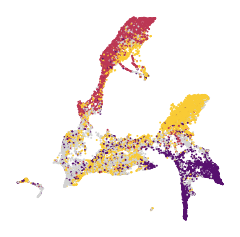

In [30]:
plot_IN_lineages(adata,'TelSubpallium12wk_IN_lineages2')

Telencephalon 12 p.c.w

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


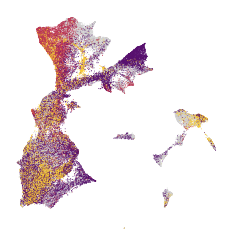

In [49]:
plot_IN_lineages(adata,'TelSubpallium6wk_IN_lineages')

Telencephalon 6 p.c.w

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


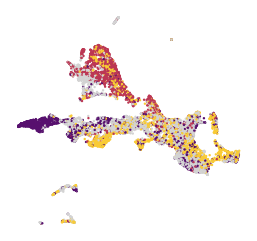

In [13]:
plot_IN_lineages(adata,'TelSubpallium7wk_IN_lineages')

Telencephalon 7 p.c.w

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


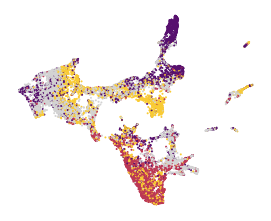

In [56]:
plot_IN_lineages(adata,'TelSubpallium8wk_IN_lineages')

Telencephalon 8 p.c.w

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


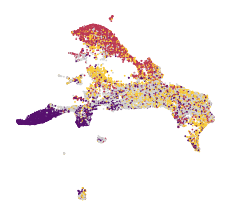

In [62]:
plot_IN_lineages(adata,'TelSubpallium9wk_IN_lineages')

Telencephalon 9 p.c.w

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


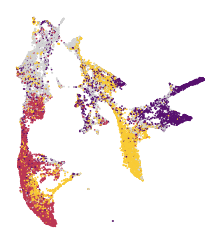

In [68]:
plot_IN_lineages(adata,'TelSubpallium11wk_IN_lineages')

Telencephalon 11 p.c.w

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


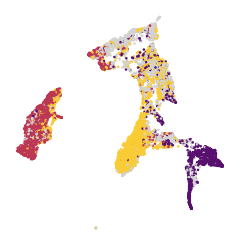

In [75]:
plot_IN_lineages(adata,'TelSubpallium13wk_IN_lineages')

Telencephalon 13 p.c.w

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


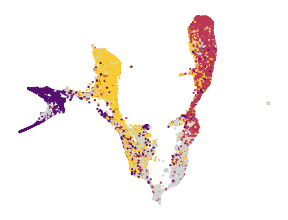

In [82]:
plot_IN_lineages(adata,'TelSubpallium14wk_IN_lineages')

Telencephalon 14 p.c.w

*Interneuron lineages of DLX2+ clusters based on marker genes signature - All region*

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


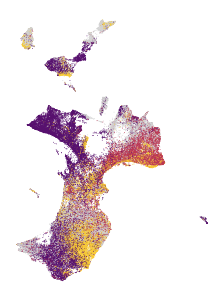

In [58]:
plot_IN_lineages(adata,'CleanPoolSubpallium6wk_IN_lineages')

6 p.c.w

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


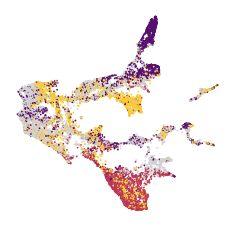

In [34]:
plot_IN_lineages(adata,'CleanPoolSubpallium8wk_IN_lineages2')

8 p.c.w

/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/proj/user/miri/anaconda3/envs/shoji2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


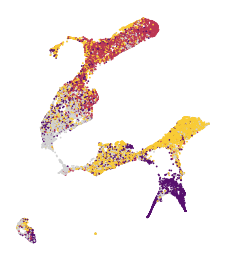

In [42]:
plot_IN_lineages(adata,'CleanPoolSubpallium14wk_IN_lineages2')

14 p.c.w

**Differentiation classes based on the CleanPool assignment**

In [10]:
ws = db["builds"]["sten"]["humandev20220523"]["PoolClean"]

In [11]:
intersect_arr, ind1, ind2 = np.intersect1d(ws.CellID[:], np.array(adata.obs_names), assume_unique=True, return_indices=True)
adata.obs['CellClass']='---'
adata.obs.iloc[ind2,np.where(adata.obs.keys() =='CellClass')[0]]= ws.CellClass[:][ind1]

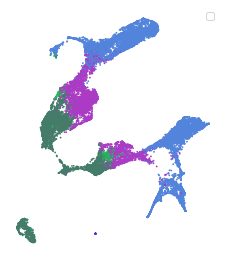

In [45]:


xy = adata.obsm['X_umap']
labels = np.array(adata.obs.loc[:,'CellClass'])
plt.figure(None, ((np.abs(np.max(xy[:,0])-np.min(xy[:,0]))/5), (np.abs(np.max(xy[:,1])-np.min(xy[:,1]))/5)))
#cgplot.scatterc(xy,c= labels, colors="classes", legend="upper right",rasterized=True)
cgplot.scatterc(xy,c= labels, colors="classes", rasterized=True)
plt.axis("off")
plt.legend('')
plt.savefig('differentiation_Subpallium14wk.pdf',dpi=200)
None

*Telencephalon 12 p.c.w*

In [42]:
intersect_arr, ind1, ind2 = np.intersect1d(ws.CellID[:], np.array(adata.obs_names), assume_unique=True, return_indices=True)
adata.obs['CellClass']='---'
adata.obs.iloc[ind2,np.where(adata.obs.keys() =='CellClass')[0]]= ws.CellClass[:][ind1]

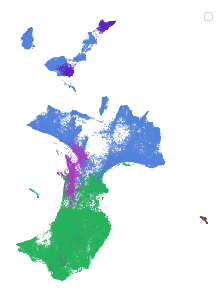

In [94]:


xy = adata.obsm['X_umap']
labels = np.array(adata.obs.loc[:,'CellClass'])
plt.figure(None, ((np.abs(np.max(xy[:,0])-np.min(xy[:,0]))/5), (np.abs(np.max(xy[:,1])-np.min(xy[:,1]))/5)))
#cgplot.scatterc(xy,c= labels, colors="classes", legend="upper right",rasterized=True)
cgplot.scatterc(xy,c= labels, colors="classes", rasterized=True)
plt.axis("off")
plt.legend('')
plt.savefig('differentiation_Subpallium6wk.pdf',dpi=200)
None

*6 p.c.w*

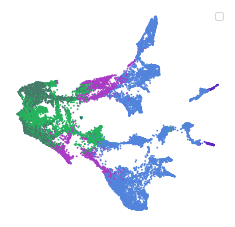

In [12]:
xy = adata.obsm['X_umap']
labels = np.array(adata.obs.loc[:,'CellClass'])
plt.figure(None, ((np.abs(np.max(xy[:,0])-np.min(xy[:,0]))/5), (np.abs(np.max(xy[:,1])-np.min(xy[:,1]))/5)))
#cgplot.scatterc(xy,c= labels, colors="classes", legend="upper right",rasterized=True)
cgplot.scatterc(xy,c= labels, colors="classes", rasterized=True)
plt.axis("off")
plt.legend('')
plt.savefig('differentiation_Subpallium8wk.pdf',dpi=200)
None

*8 p.c.w*

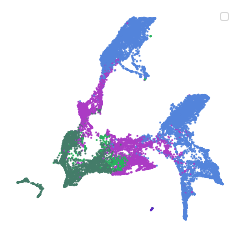

In [36]:


xy = adata.obsm['X_umap']
labels = np.array(adata.obs.loc[:,'CellClass'])
plt.figure(None, ((np.abs(np.max(xy[:,0])-np.min(xy[:,0]))/5), (np.abs(np.max(xy[:,1])-np.min(xy[:,1]))/5)))
cgplot.scatterc(xy,c= labels, colors="classes", rasterized=True)
plt.axis("off")
plt.legend('')
plt.savefig('differentiation_TelSubpallium12wk2.pdf',dpi=200)
None

*14 p.c.w*

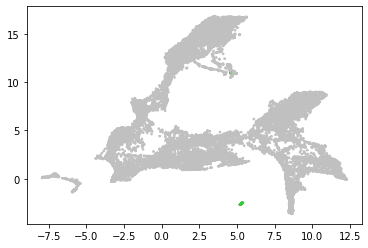

In [29]:
labels = (adata.obs.loc[:,'CellClass']=='Neuroblast').astype(int)
pind = np.random.permutation(adata.obs.shape[0])
#cgplot.scatterc(xy,c= labels, colors="classes", legend="upper right",rasterized=True)
plt.scatter(xy[pind,0], xy[pind,1],c= np.array(['silver','limegreen'])[labels.values[pind]],s = 3, rasterized=True)

**Gene expression**

In [33]:
general_genes= ['FOXG1',  'DLX2','EMX1']

In [29]:
RG_genes= ['SLC1A3',  'HES1','FAM107A','HES5','ADGRV1','TNC','BCAN','VIM','NES']

In [25]:
NPC_genes= ['MKI67','KPNA2','CENPF','UBE2C','GAD2']

In [27]:
NPC_genes2= ['MKI67','ASCL1','HES6','DLX2']

In [19]:
Neuroblast_genes= ['NHLH1','NHLH2']

In [41]:
LGE_genes = ['MEIS2','FOXP2','FOXP1','ISL1','EBF1','TAC1','PDYN',#striatonigral (D1) MSNs - vLGE
             'PENK',#striatopallidal (D2) MSNs - vLGE
                    'NPY1R',
                    'TSHZ1','ETV1',#striatonigral (D1) MSNs - dLGE
                     'SCGN',
                    'PAX6',
                    
                    'CALB1'
                    ]

In [41]:
LGE_genes2 = ['MEIS2','FOXP2','FOXP1','ISL1','EBF1','TAC1','PDYN',#striatonigral (D1) MSNs - vLGE
             'PENK',#striatopallidal (D2) MSNs - vLGE
                    'NPY1R',
                    'TSHZ1','ETV1',#striatonigral (D1) MSNs - dLGE
                     'SCGN',
                    'PAX6',
                    
                    'CALB1'
                    ]

In [44]:
MGE_genes = ['NKX2-1','LHX6','SOX6','MAF','SST','CHODL','CRABP1','ANGPT2','ETV1']

In [46]:
CGE_genes = ['PROX1','NR2F1','NFIX','NR2F2','SP8','CALB2','CCK','VIP','DPY19L1']

**12 p.c.w Telencephalon**

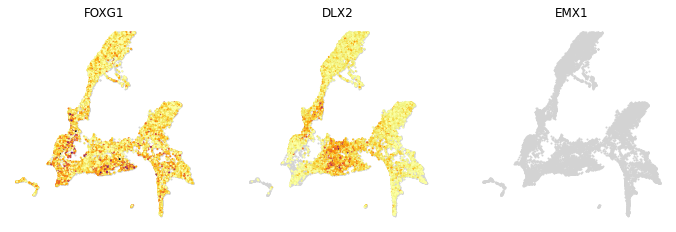

In [41]:
plot_markers(view,general_genes, height=2, width =5, file_name= 'Tel_Subpallium_12wk_general_markers')

Telencephalon 12 p.c.w - Patterning genes 

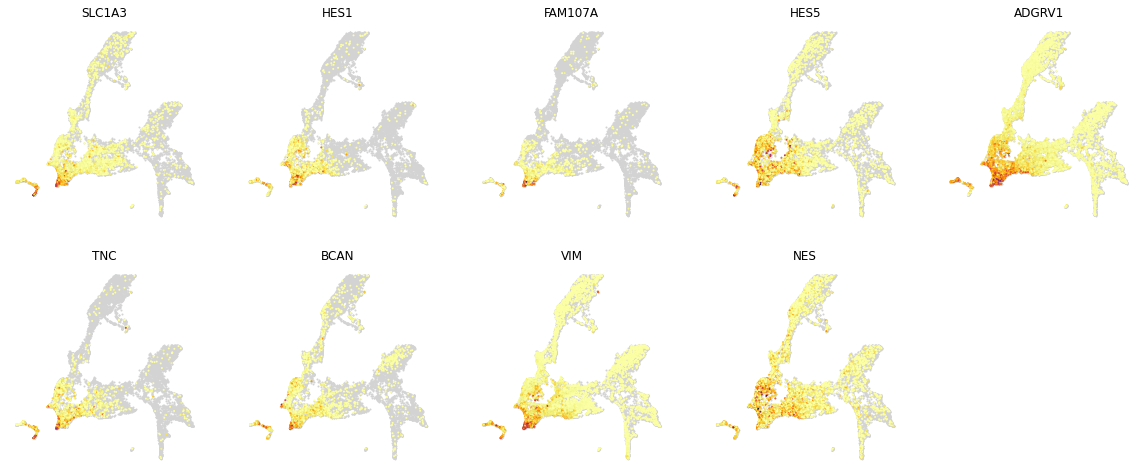

In [40]:
plot_markers(view,RG_genes, height=2, width =5, file_name= 'Tel_Subpallium_12wk_RG_markers')

Telencephalon 12 p.c.w - Radial glia markers

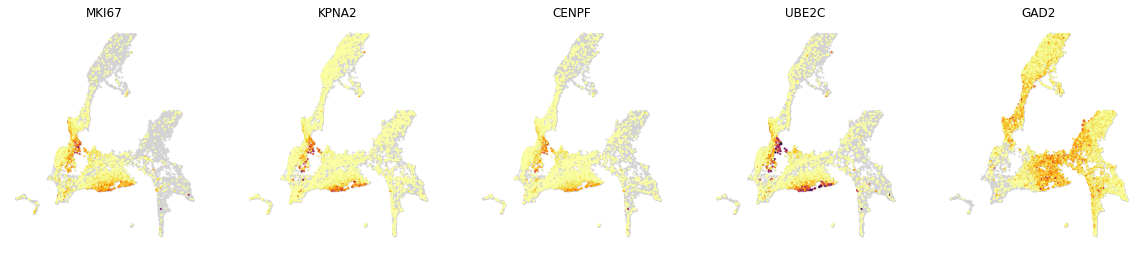

In [26]:
plot_markers(view,NPC_genes, height=1, width =5, file_name= 'Tel_Subpallium_12wk_NPC_markers')

Telencephalon 12 p.c.w - IPC markers

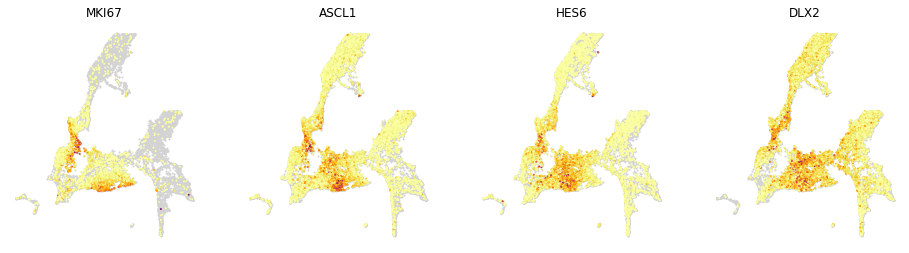

In [28]:
plot_markers(view,NPC_genes2, height=1, width =5, file_name= 'Tel_Subpallium_12wk_NPC_markers2')

Telencephalon 12 p.c.w - IPC markers 

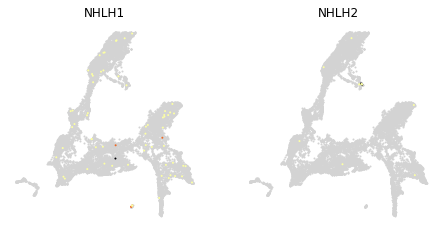

In [20]:
plot_markers(view,Neuroblast_genes, height=2, width =5, file_name= 'Tel_Subpallium_12wk_Neuroblast_markers')

Telencephalon 12 p.c.w - Neuroblast markers

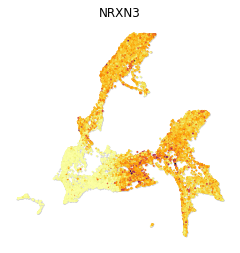

In [13]:
plot_markers(view,['NRXN3'], height=1, width =1)

Telencephalon 12 p.c.w - NRXN3 gene

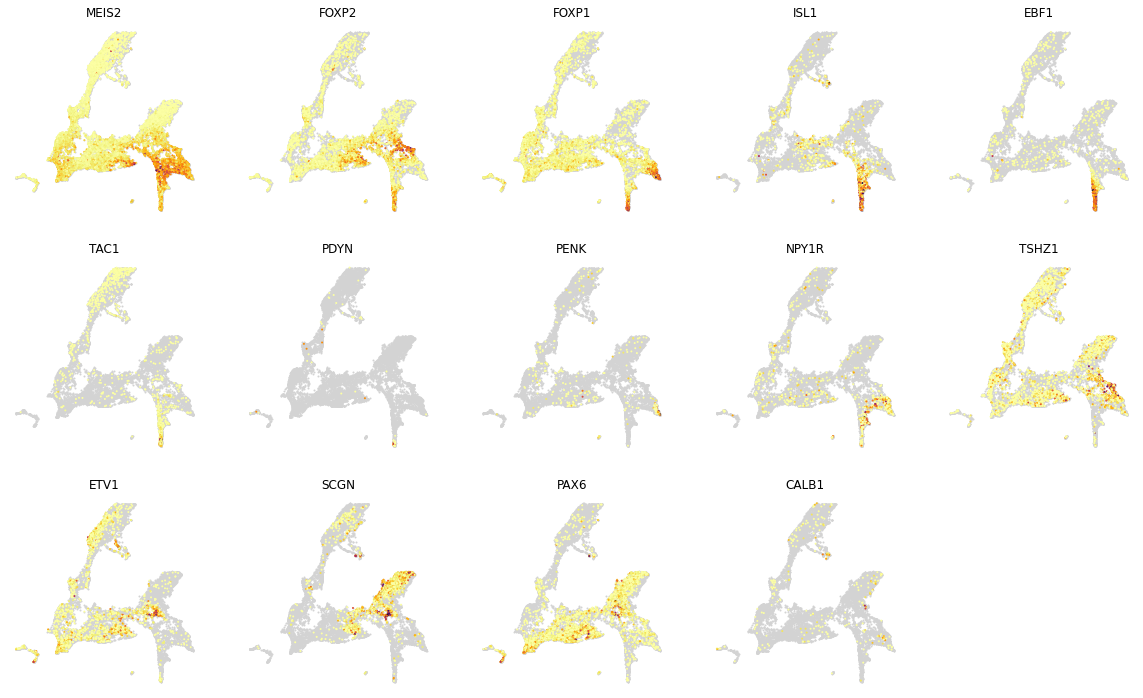

In [49]:
plot_markers(view,LGE_genes, height=3, width =5, file_name= 'CleanPoolTelSubpal12wk_LGE_markers')

Telencephalon 12 p.c.w - LGE markers

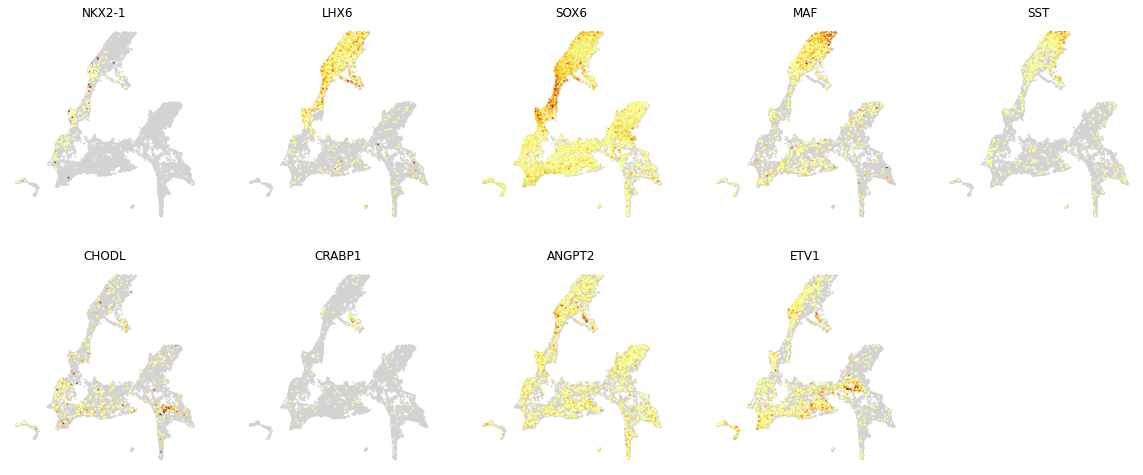

In [50]:
plot_markers(view,MGE_genes, height=2, width =5, file_name= 'CleanPoolTelSubpal12wk_MGE_genes_markers')

Telencephalon 12 p.c.w - MGE markers

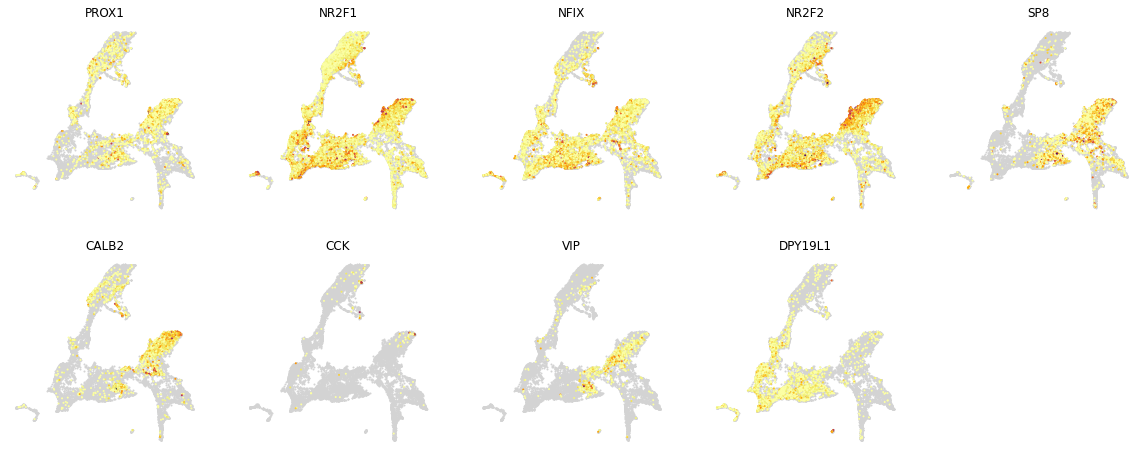

In [51]:
plot_markers(view,CGE_genes, height=4, width =5, file_name= 'CleanPoolTelSubpal12wk_CGE_genes_markers')

Telencephalon 12 p.c.w - CGE markers

**6 p.c.w**

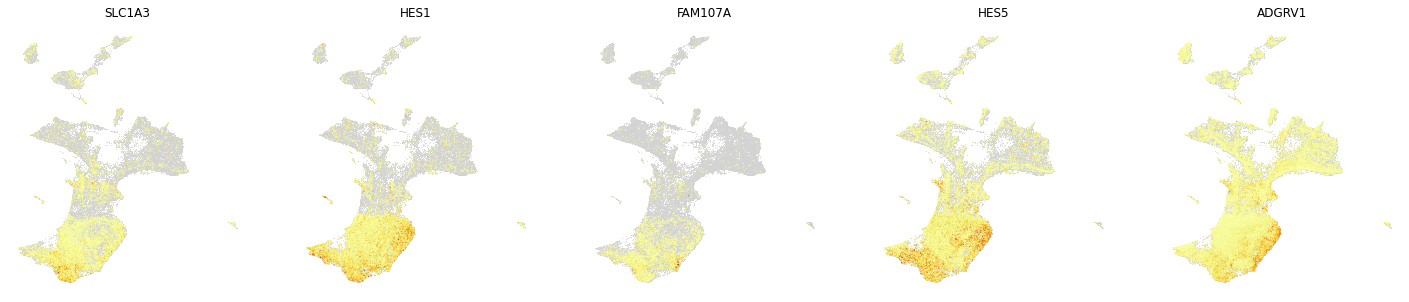

In [100]:
plot_markers(view,RG_genes, height=1, width =5, file_name= 'CleanPoolSubpallium6wk_RG_markers')

6 p.c.w - Radial glia markers

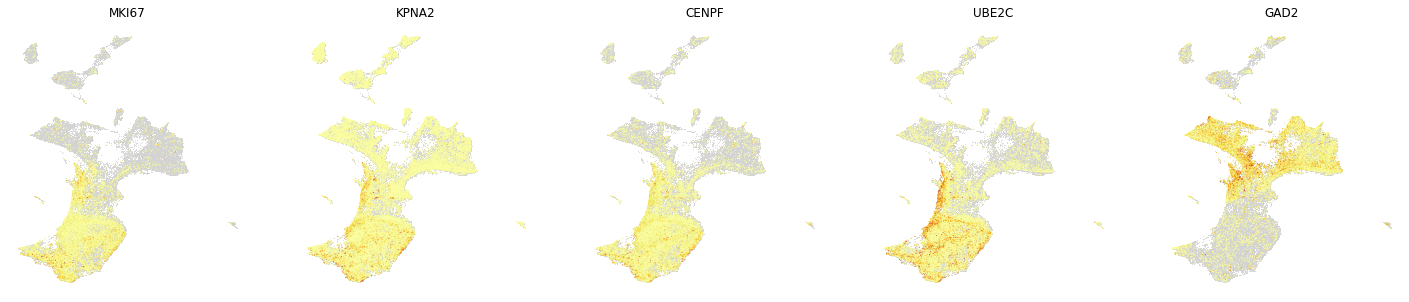

In [101]:
plot_markers(view,NPC_genes, height=1, width =5, file_name= 'CleanPoolSubpallium6wk_NPC_markers')

6 p.c.w - IPC markers

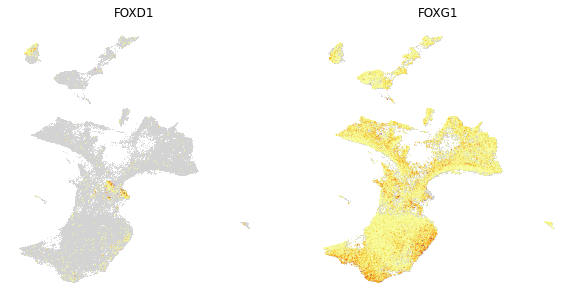

In [112]:
plot_markers(view,['FOXD1','FOXG1'], height=1, width =2, file_name= 'CleanPoolSubpallium6wk_FOXG1_FOXD1')

6 p.c.w FOXD1 and FOXG1

**8 p.c.w**

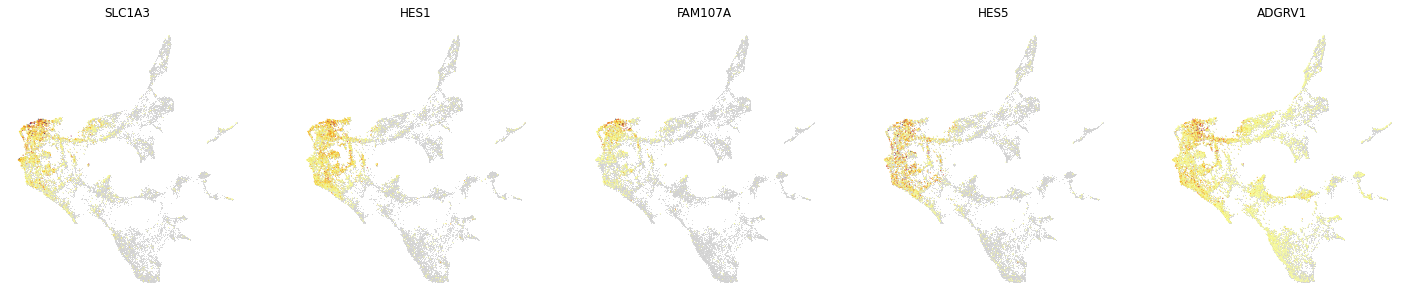

In [123]:
plot_markers(view,RG_genes, height=1, width =5, file_name= 'CleanPoolSubpallium8wk_RG_markers')

8 p.c.w - Radial glia markers

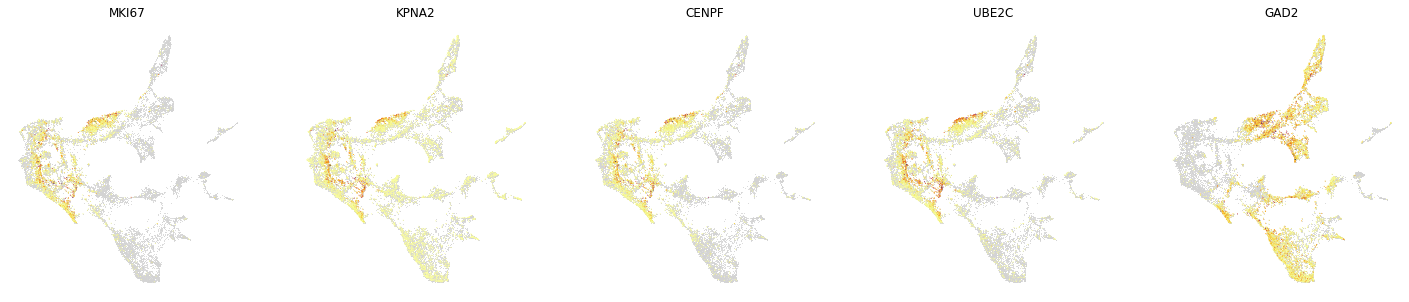

In [124]:
plot_markers(view,NPC_genes, height=1, width =5, file_name= 'CleanPoolSubpallium8wk_NPC_markers')

8 p.c.w - IPC markers

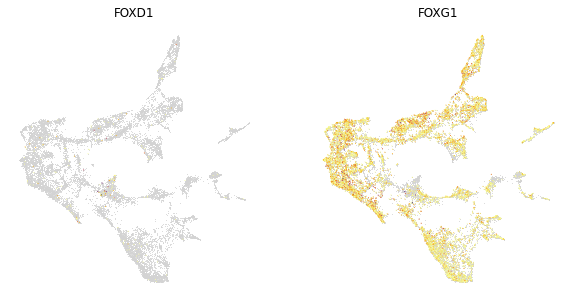

In [135]:
plot_markers(view,['FOXD1','FOXG1'], height=1, width =2, file_name= 'CleanPoolSubpallium8wk_FOXG1_FOXD1')

8 p.c.w - FOXD1 and FOXG1

**14 p.c.w**

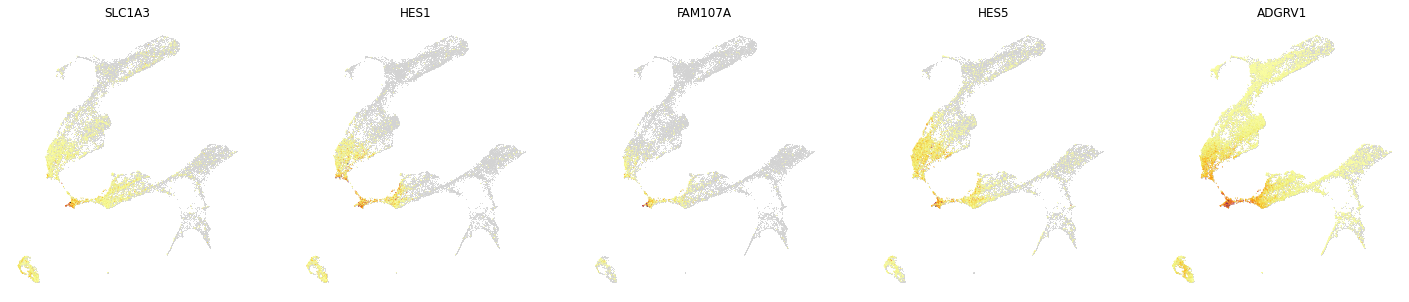

In [156]:
plot_markers(view,RG_genes, height=1, width =5, file_name= 'CleanPoolSubpallium14wk_RG_markers')

14 p.c.w - Radial glia markers

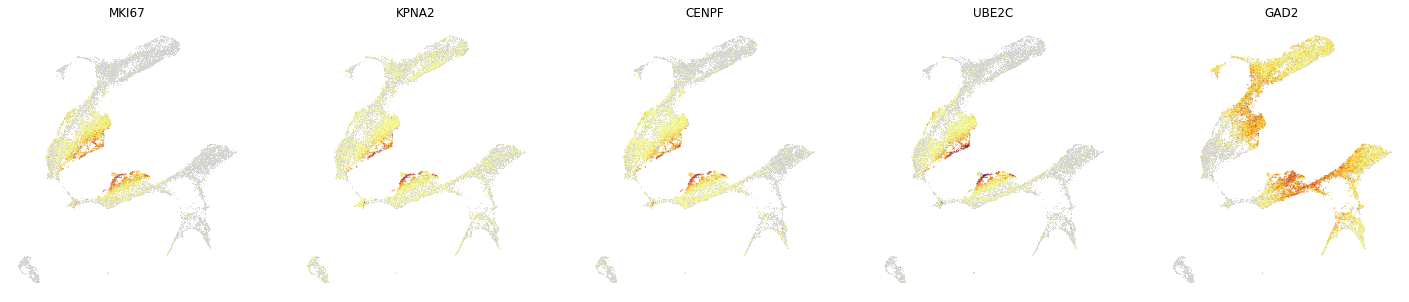

In [157]:
plot_markers(view,NPC_genes, height=1, width =5, file_name= 'CleanPoolSubpallium14wk_NPC_markers')

14 p.c.w - IPC markers

**Telencephalic samples - subregions**

In [24]:
#Plot cortex subregions for all weeks
ws_5 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium5wk"]
cells5 = ws_5.Expression[:,ws_5['Gene']=='EMX1']==0
view5 = ws_5.cells[cells5.T[0]]
ws_6 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium6wk"]
cells6 = ws_6.Expression[:,ws_6['Gene']=='EMX1']==0
view6 = ws_6.cells[cells6.T[0]]
ws_7 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium7wk"]
cells7 = ws_7.Expression[:,ws_7['Gene']=='EMX1']==0
view7 = ws_7.cells[cells7.T[0]]
ws_8 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium8wk"]
cells8 = ws_8.Expression[:,ws_8['Gene']=='EMX1']==0
view8 = ws_8.cells[cells8.T[0]]
ws_9 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium9wk"]
cells9 = ws_9.Expression[:,ws_9['Gene']=='EMX1']==0
view9 = ws_9.cells[cells9.T[0]]
ws_10 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium10wk"]
cells10 = ws_10.Expression[:,ws_10['Gene']=='EMX1']==0
view10 = ws_10.cells[cells10.T[0]]
ws_11 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium11wk"]
cells11 = ws_11.Expression[:,ws_11['Gene']=='EMX1']==0
view11 = ws_11.cells[cells11.T[0]]
ws_12 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium12wk"]
cells12 = ws_12.Expression[:,ws_12['Gene']=='EMX1']==0
view12 = ws_12.cells[cells12.T[0]]
ws_13 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium13wk"]
cells13 = ws_13.Expression[:,ws_13['Gene']=='EMX1']==0
view13 = ws_13.cells[cells13.T[0]]
ws_14 = db["builds"]["sten"]["humandev20220523"]["TelencephalonSubpallium14wk"]
cells14 = ws_14.Expression[:,ws_14['Gene']=='EMX1']==0
view14 = ws_14.cells[cells14.T[0]]

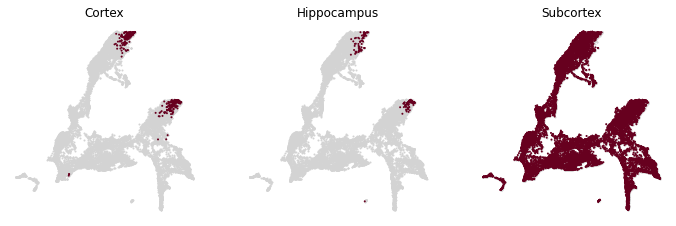

In [26]:
plot_subregions(view12,np.unique(view12['Subregion']),height=3,width = 5, file_name = 'SubpalliumTel12wk_subregions')

12 p.c.w

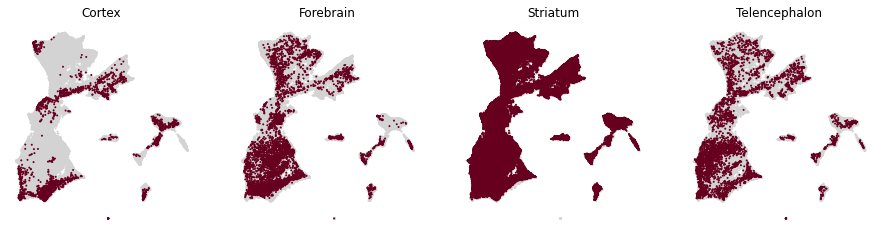

In [27]:
plot_subregions(view6,np.unique(view6['Subregion']),height=3,width = 5, file_name = 'SubpalliumTel6wk_subregions')

6 p.c.w

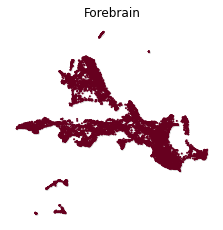

In [28]:
plot_subregions(view7,np.unique(view7['Subregion']),height=3,width = 5, file_name = 'SubpalliumTel7wk_subregions')

7 p.c.w

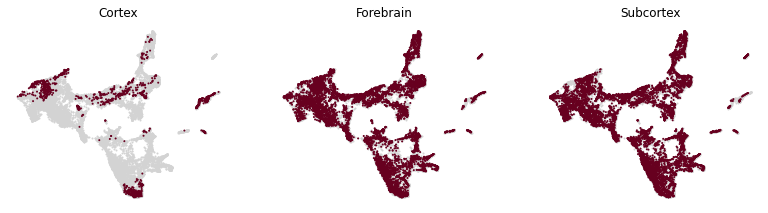

In [29]:
plot_subregions(view8,np.unique(view8['Subregion']),height=3,width = 5, file_name = 'SubpalliumTel8wk_subregions')

8 p.c.w 

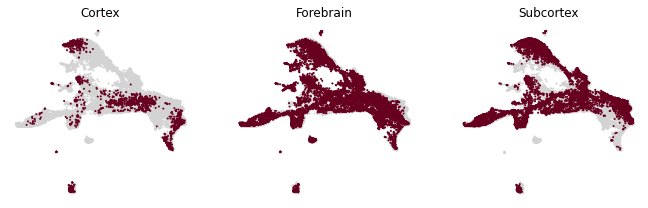

In [30]:
plot_subregions(view9,np.unique(view9['Subregion']),height=3,width = 5, file_name = 'SubpalliumTel9wk_subregions')

9 p.c.w

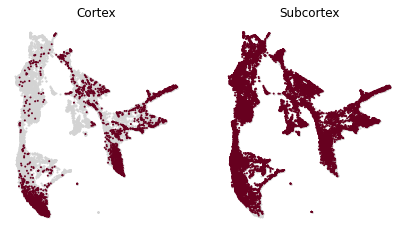

In [32]:
plot_subregions(view11,np.unique(view11['Subregion']),height=3,width = 5, file_name = 'SubpalliumTel11wk_subregions')

11 p.c.w

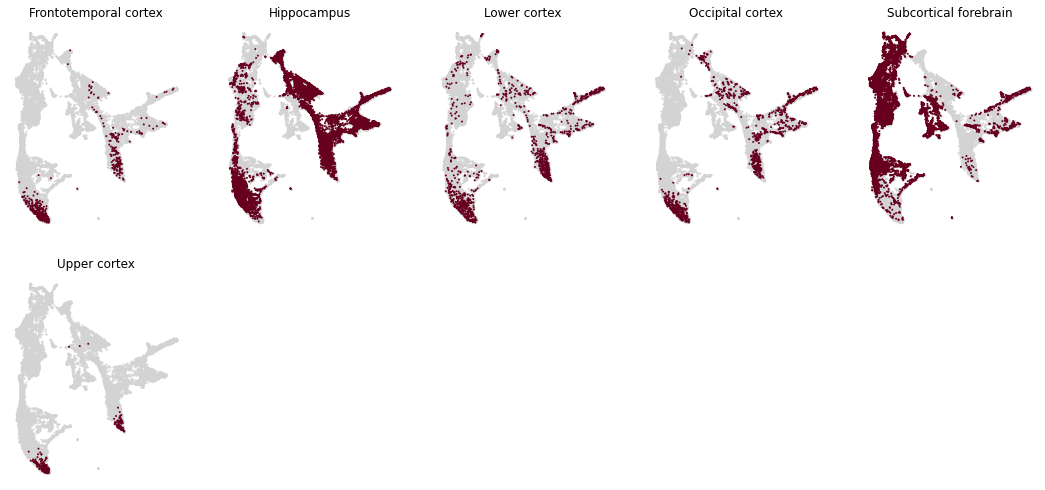

In [34]:
plot_subregions(view11,np.unique(view11['Tissue']).tolist(),height=2,file_name = 'TelencephalonSubpallium11wk_tissue2')

11 p.c.w cortex subdivision

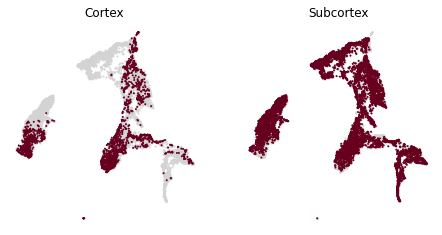

In [37]:
plot_subregions(view13,np.unique(view13['Subregion']),height=3,width = 5, file_name = 'SubpalliumTel13wk_subregions')

13 p.c.w

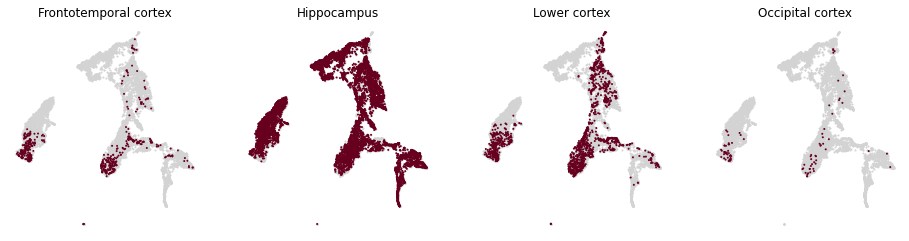

In [35]:
plot_subregions(view13,np.unique(view13['Tissue']).tolist(),height=2,file_name = 'TelencephalonSubpallium13wk_tissue2')

13 p.c.w cortex subdivision

**All samples - Thalamus and hypothalamus**

In [17]:
ws_6 = db["builds"]["sten"]["humandev20220523"]["Subpallium6wk"]
cells6 = np.bitwise_and(ws_6.Expression[:,ws_6['Gene']=='EMX1']==0,ws_6.Expression[:,ws_6['Gene']=='DLX2']>0)
view6a_DLX2 = ws_6.cells[cells6.T[0]]
ws_8 = db["builds"]["sten"]["humandev20220523"]["Subpallium8wk"]
cells8 = np.bitwise_and(ws_8.Expression[:,ws_8['Gene']=='EMX1']==0,ws_8.Expression[:,ws_8['Gene']=='DLX2']>0)
view8a_DLX2 = ws_8.cells[cells8.T[0]]
ws_14 = db["builds"]["sten"]["humandev20220523"]["Subpallium14wk"]
cells14 = np.bitwise_and(ws_14.Expression[:,ws_14['Gene']=='EMX1']==0,ws_14.Expression[:,ws_14['Gene']=='DLX2']>0)
view14a_DLX2 = ws_14.cells[cells14.T[0]]

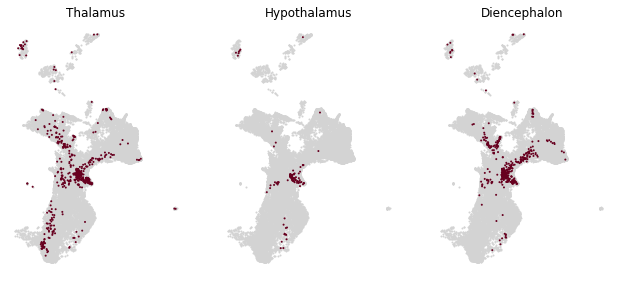

In [18]:
plot_subregions(view6a_DLX2,['Thalamus','Hypothalamus','Diencephalon'],height=3,width = 5, file_name = 'Subpallium6wk_subregions2_DLX2')

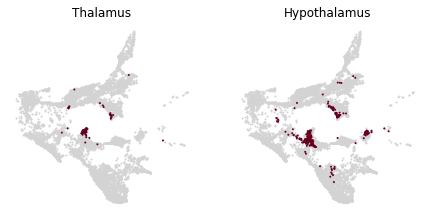

In [19]:
plot_subregions(view8a_DLX2,['Thalamus','Hypothalamus'],height=3,width = 5, file_name = 'Subpallium8wk_subregions2_DLX2')

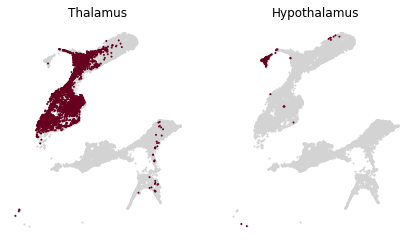

In [20]:
plot_subregions(view14a_DLX2,['Thalamus','Hypothalamus'],height=3,width = 5, file_name = 'Subpallium14wk_subregions2_DLX2')

In [32]:
del view6a_DLX2,view8a_DLX2,view14a_DLX2

**Comapere thalamic cells marker gene expression to other cells within the same cluster**

In [27]:
#Plot cortex subregions for all weeks
ws_6 = db["builds"]["sten"]["humandev20220523"]["Subpallium6wk"]
cells6 = ws_6.Expression[:,ws_6['Gene']=='EMX1']==0
view6a = ws_6.cells[cells6.T[0]]
ws_8 = db["builds"]["sten"]["humandev20220523"]["Subpallium8wk"]
cells8 = ws_8.Expression[:,ws_8['Gene']=='EMX1']==0
view8a = ws_8.cells[cells8.T[0]]
ws_14 = db["builds"]["sten"]["humandev20220523"]["Subpallium14wk"]
cells14 = ws_14.Expression[:,ws_14['Gene']=='EMX1']==0
view14a = ws_14.cells[cells14.T[0]]

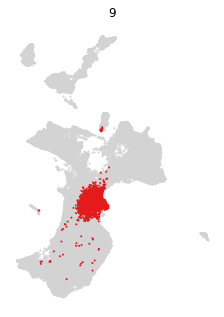

In [23]:
plot_cluster(view6a,[9],1,1,file_name = 'cluster9_FOXD1_6pcw')

Cluster 9 - 6 p.c.w

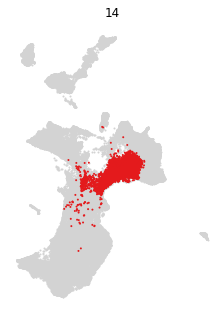

In [24]:
plot_cluster(view6a,[14],1,1,file_name = 'cluster14_MGE_6pcw')

Cluster 14 - 6 p.c.w

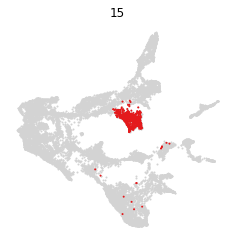

In [25]:
plot_cluster(view8a,[15],1,1,file_name = 'cluster15_CALB2_8pcw')

Cluster 15 - 8 p.c.w

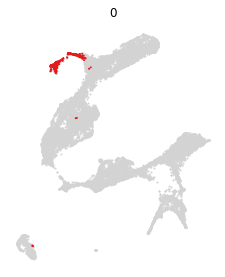

In [28]:
plot_cluster(view14a,[0],1,1,file_name = 'cluster0_CRABP1_14pcw')

Cluster 0 - 14 p.c.w

In [6]:
ws = db["builds"]["sten"]["humandev20220523"]["Subpallium6wk"]


In [116]:
#Compare gene expression within a cluster 
cluster_cells = ws.Clusters[:]==9
np.unique(ws.Subregion[cluster_cells,:])
hypothalamus_cells = ws.Subregion[cluster_cells,:]=='Hypothalamus'
thalamus_cells = ws.Subregion[cluster_cells,:]=='Thalamus'
diencephalon_cells =ws.Subregion[cluster_cells,:]=='Diencephalon'
striatum_cells =ws.Subregion[cluster_cells,:]=='Striatum'


In [117]:
view_cluster9 = ws.cells[cluster_cells]

In [27]:
ws['Gene']=='FOXG1'

(Gene == FOXG1)

In [118]:
d = {'DLX2': view_cluster9.Expression[:,view_cluster9['Gene'][:]== 'DLX2'].T.flatten(),'FOXG1': view_cluster9.Expression[:,view_cluster9['Gene'][:]== 'FOXG1'].T.flatten(),'FOXD1': view_cluster9.Expression[:,view_cluster9['Gene'][:]== 'FOXD1'].T.flatten()}

df = pd.melt( pd.DataFrame(data = d), var_name = 'x', value_name = 'y')

df['Subregion'] = np.tile(view_cluster9['Subregion'][:],3)



In [58]:
df

x  y  Subregion
0       DLX2  2   Striatum
1       DLX2  3   Striatum
2       DLX2  9   Striatum
3       DLX2  0   Striatum
4       DLX2  0   Striatum
...      ... ..        ...
16828  FOXD1  4      Brain
16829  FOXD1  1      Brain
16830  FOXD1  2      Brain
16831  FOXD1  0      Brain
16832  FOXD1  0  Forebrain

[16833 rows x 3 columns]

In [119]:
df2 = df[np.logical_or.reduce(np.array((df['Subregion']=='Striatum',df['Subregion']=='Thalamus',df['Subregion']=='Hypothalamus',df['Subregion']=='Diencephalon')))]

In [113]:
import seaborn as sns
sns.set(rc={'figure.figsize':(5,10)})
sns.set_style("whitegrid", {'axes.grid' : False})
for i,g in enumerate(np.unique(df2['gene']):
    g = sns.catplot(data=df2[df2['gene']==g], x="x", y="y", hue = 'Subregion',kind="violin", scale = 'width',scale_hue=False,cut = 0, inner=None,width = 1 , orient = 'h')
g.savefig('violin_FOXD1_cells_FO_6wk.pdf',dpi=200)

NameError: name 'df2' is not defined

In [18]:
import seaborn as sns

def plot_violins(ws,genes,cluster, height= 3,width= 5, file_name = ''):
    sns.set(rc={'figure.figsize':(5,10)})
    sns.set_style("whitegrid", {'axes.grid' : False})
    genes_num = len(genes)
    if(file_name == ''):
        file_name = genes[0]+'_violin'
    #xy = adata.obsm['Embedding']
    #xy = view.Embedding
    cluster_cells = ws.Clusters[:]==cluster
    view_cluster= ws.cells[cluster_cells]
    #plt.figure(None, ((np.abs(np.max(xy[:,0])-np.min(xy[:,0]))/5)*width, (np.abs(np.max(xy[:,1])-np.min(xy[:,1]))/5)*height))
    fig, axes = plt.subplots(1, genes_num, figsize=(15, 5), sharey=False)
    for i, gene in enumerate(genes):
        
        d = {gene: view_cluster.Expression[:,view_cluster['Gene'][:]== gene].T.flatten()}
        df = pd.melt( pd.DataFrame(data = d), var_name = 'y', value_name = 'x')
        df['Subregion'] = view_cluster['Subregion'][:]
        
       # df2 = df[np.logical_or.reduce(np.array((df['Subregion']=='Striatum',df['Subregion']=='Thalamus',df['Subregion']=='Hypothalamus',df['Subregion']=='Diencephalon')))]
       # df2 = df[np.logical_or.reduce(np.array((df['Subregion']=='Forebrain',df['Subregion']=='Thalamus',df['Subregion']=='Hypothalamus')))]

        df2 = df[np.logical_or.reduce(np.array((df['Subregion']=='Hippocampus',df['Subregion']=='Striatum',df['Subregion']=='Subcortex',df['Subregion']=='Cortex',df['Subregion']=='Thalamus',df['Subregion']=='Hypothalamus',df['Subregion']=='Forebrain',df['Subregion']=='Diencephalon',df['Subregion']=='Telencephalon')))]
        # 6pcw
        #cluster 9
        #t = pd.CategoricalDtype(categories=['Striatum','Forebrain','Cortex','Telencephalon','Diencephalon','Thalamus','Hypothalamus'], ordered=True)
        
        #Cluster 14
        #t = pd.CategoricalDtype(categories=['Striatum','Forebrain','Telencephalon','Diencephalon','Thalamus'], ordered=True)
        

        # 8 pcw
        #t = pd.CategoricalDtype(categories=['Subcortex','Forebrain','Thalamus','Hypothalamus'], ordered=True)
        
        #14 pcw
        t = pd.CategoricalDtype(categories=['Striatum','Thalamus','Hypothalamus'], ordered=True)
        
        df2['Subregion']=df2['Subregion'].astype(t)
        sns.set(rc={'figure.figsize':(5,10)})
        #6 pcw
        #cluster 9 
        #sns.violinplot(ax=axes[i], data=df2, x="x", y="y", hue = 'Subregion', scale = 'width',scale_hue=False,cut = 0, inner=None,width = 1 , palette = {'Striatum': "#f34a4a",'Forebrain':"#f26b38",'Diencephalon':"#e9c413",'Cortex':"#eb6355",'Thalamus':"#e1f5c4", 'Hypothalamus':"#c9a403", 'Telencephalon':"#cb4335"})
        #cluster 14
        #sns.violinplot(ax=axes[i], data=df2, x="x", y="y", hue = 'Subregion', scale = 'width',scale_hue=False,cut = 0, inner=None,width = 1 , palette = {'Striatum': "#f34a4a",'Forebrain':"#f26b38",'Diencephalon':"#e9c413",'Thalamus':"#e1f5c4", 'Telencephalon':"#cb4335"})
        
        #8pcw
        #sns.violinplot(ax=axes[i], data=df2, x="x", y="y", hue = 'Subregion', scale = 'width',scale_hue=False,cut = 0, inner=None,width = 1 , palette = { 'Subcortex':"#fc9d9a",'Forebrain':"#f26b38", 'Thalamus':"#e1f5c4", 'Hypothalamus':"#c9a403"})
        
        #14 pcw
        sns.violinplot(ax=axes[i], data=df2, x="x", y="y", hue = 'Subregion', scale = 'width',scale_hue=False,cut = 0, inner=None,width = 1 , palette = { 'Striatum': "#f34a4a", 'Thalamus':"#e1f5c4", 'Hypothalamus':"#c9a403"})
        
    plt.savefig(file_name+'.pdf',dpi=200)

In [36]:
ws = db["builds"]["sten"]["humandev20220523"]["Subpallium9wk"]

In [206]:
cluster_cells = ws.Clusters[:]==9
view_cluster= ws.cells[cluster_cells]

In [207]:
np.unique(view_cluster['Subregion'],return_counts = True)

(array(['Brain', 'Cortex', 'Diencephalon', 'Forebrain', 'Hypothalamus',
        'Medulla', 'Midbrain', 'Midbrain dorsal', 'Pons', 'Striatum',
        'Telencephalon', 'Thalamus'], dtype=object),
 array([ 689,   29,  546,  438,  304,   12,   20,    4,   15, 2649,  156,
         749]))

/var/lib/condor/execute/dir_13228/ipykernel_222500/1680702951.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subregion']=df2['Subregion'].astype(t)
/var/lib/condor/execute/dir_13228/ipykernel_222500/1680702951.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subregion']=df2['Subregion'].astype(t)
/var/lib/condor/execute/dir_13228/ipykernel_222500/1680702951.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

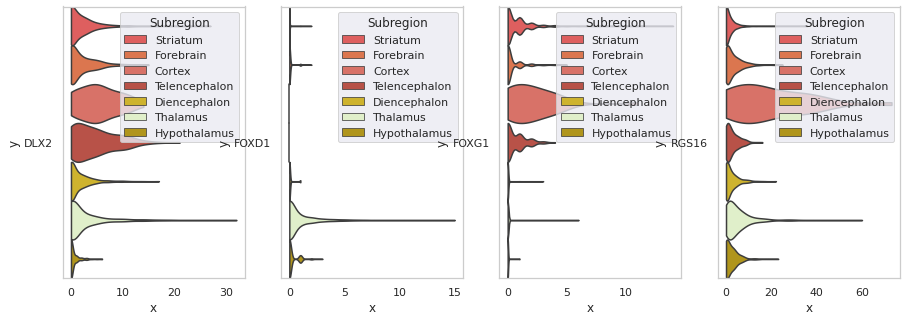

In [225]:
plot_violins(ws_6,['DLX2','FOXD1','FOXG1','RGS16'],9,1,3,'cluster9_6pcw_FOXD1')

In [34]:
cluster_cells = ws.Clusters[:]==1
view_cluster= ws.cells[cluster_cells]

In [35]:
np.unique(view_cluster['Subregion'],return_counts = True)

(array(['Forebrain', 'Hypothalamus', 'Midbrain', 'Midbrain ventral',
        'Subcortex', 'Thalamus'], dtype=object),
 array([392,  99,   1,   7, 383,  15]))

In [37]:
cluster_cells = ws.Clusters[:]==8
view_cluster= ws.cells[cluster_cells]

In [38]:
np.unique(view_cluster['Subregion'],return_counts = True)

(array(['Cortex', 'Forebrain', 'Subcortex'], dtype=object),
 array([ 72, 594, 337]))

/var/lib/condor/execute/dir_13228/ipykernel_487851/4220040029.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subregion']=df2['Subregion'].astype(t)
/var/lib/condor/execute/dir_13228/ipykernel_487851/4220040029.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subregion']=df2['Subregion'].astype(t)
/var/lib/condor/execute/dir_13228/ipykernel_487851/4220040029.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

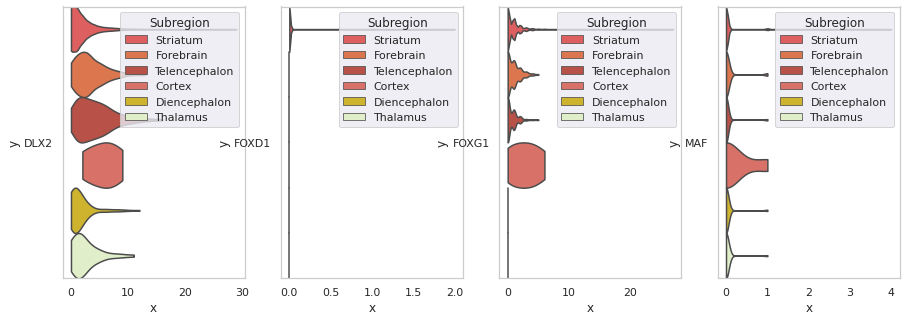

In [20]:
plot_violins(ws,['DLX2','FOXD1','FOXG1','MAF'],14,1,3,'cluster14_6pcw_FOXD1')

In [14]:
cluster_cells = ws.Clusters[:]==12
view_cluster= ws.cells[cluster_cells]

In [15]:
np.unique(view_cluster['Subregion'],return_counts = True)

(array(['Brain', 'Cortex', 'Diencephalon', 'Forebrain', 'Hypothalamus',
        'Medulla', 'Midbrain', 'Pons', 'Striatum', 'Telencephalon',
        'Thalamus'], dtype=object),
 array([ 415,  368,  100,  133,   10,    1,    1,    3, 5199,  255,   93]))

In [236]:
ws = db["builds"]["sten"]["humandev20220523"]["Subpallium8wk"]


In [237]:
cluster_cells = ws.Clusters[:]==15
view_cluster= ws.cells[cluster_cells]

In [238]:
np.unique(view_cluster['Subregion'],return_counts = True)

(array(['Forebrain', 'Hypothalamus', 'Midbrain', 'Midbrain ventral',
        'Subcortex', 'Thalamus'], dtype=object),
 array([392,  99,   1,   7, 383,  15]))

/var/lib/condor/execute/dir_13228/ipykernel_222500/1056496306.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subregion']=df2['Subregion'].astype(t)
/var/lib/condor/execute/dir_13228/ipykernel_222500/1056496306.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subregion']=df2['Subregion'].astype(t)
/var/lib/condor/execute/dir_13228/ipykernel_222500/1056496306.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

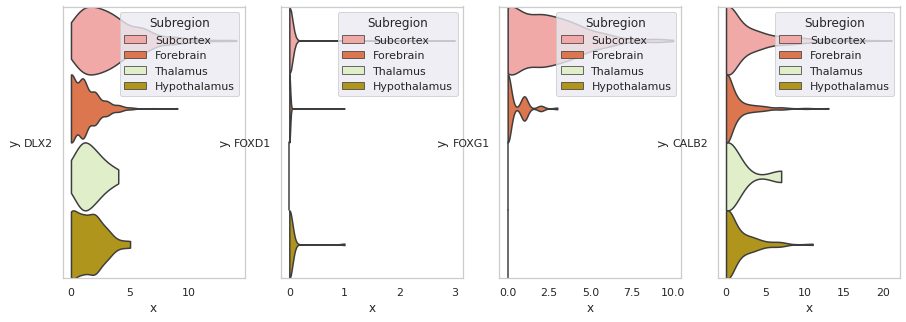

In [246]:
plot_violins(ws,['DLX2','FOXD1','FOXG1','CALB2'],15,1,4,'cluster15_8pcw_CALB2')

In [243]:
cluster_cells = ws.Clusters[:]==7
view_cluster= ws.cells[cluster_cells]

In [244]:
np.unique(view_cluster['Subregion'],return_counts = True)

(array(['Cortex', 'Forebrain', 'Hypothalamus', 'Medulla', 'Midbrain',
        'Midbrain ventral', 'Subcortex', 'Thalamus'], dtype=object),
 array([  4, 234, 471,   1,   1,  11, 373, 150]))

In [261]:
ws = db["builds"]["sten"]["humandev20220523"]["Subpallium14wk"]

In [262]:
cluster_cells = ws.Clusters[:]==0
view_cluster= ws.cells[cluster_cells]

In [263]:
np.unique(view_cluster['Subregion'],return_counts=True)

(array(['Hippocampus', 'Hypothalamus', 'Midbrain dorsal', 'Striatum',
        'Thalamus'], dtype=object),
 array([  9, 280,   2,  64,  65]))

/var/lib/condor/execute/dir_13228/ipykernel_222500/4216300698.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subregion']=df2['Subregion'].astype(t)
/var/lib/condor/execute/dir_13228/ipykernel_222500/4216300698.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subregion']=df2['Subregion'].astype(t)
/var/lib/condor/execute/dir_13228/ipykernel_222500/4216300698.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

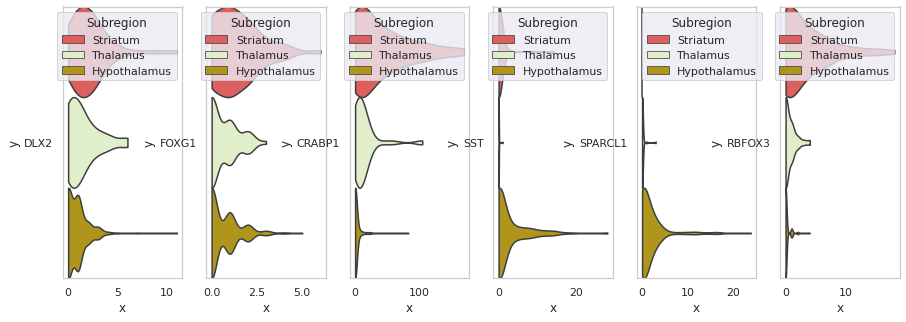

In [307]:
plot_violins(ws,['DLX2','FOXG1','CRABP1','SST','SPARCL1','RBFOX3'],0,1,4,'cluster0_14pcw_CRABP1')

**Plot marker genes**

In [184]:
df2 = df[np.logical_or.reduce(np.array((df['Subregion']=='Striatum',df['Subregion']=='Thalamus',df['Subregion']=='Hypothalamus',df['Subregion']=='Diencephalon')))]

In [ ]:
ws = db["builds"]["sten"]["humandev20220523"]["Subpallium14wk"]

In [102]:
Thalamus_genes = ['DLX2','FOXG1','FOXD1','OTP','LHX1','CALB2']

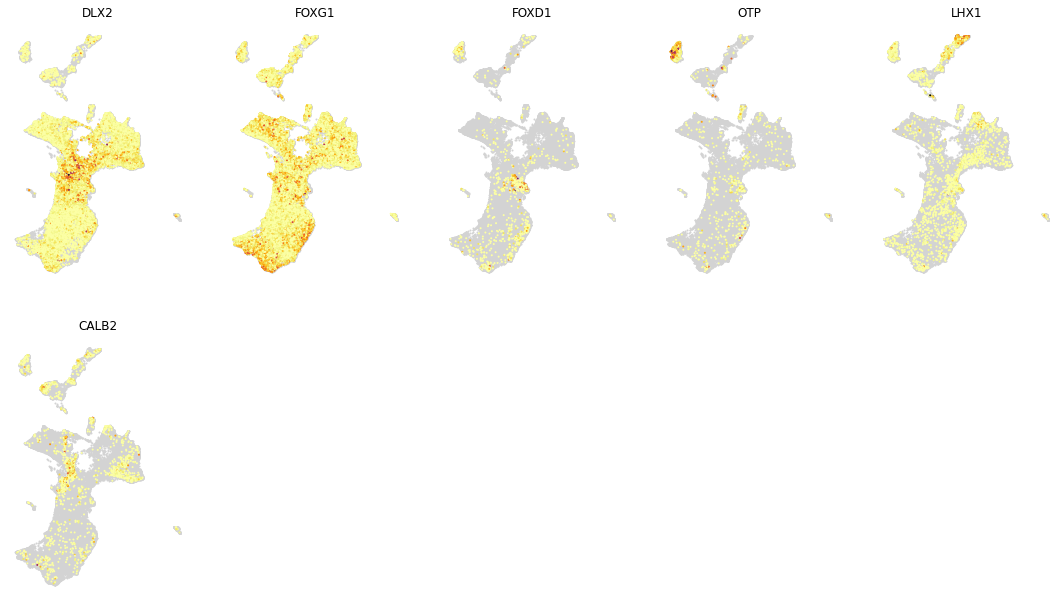

In [103]:
plot_markers(view6a,Thalamus_genes, height=2, width =5, file_name= 'Subpallium_6wk_Thalamus_genes2')

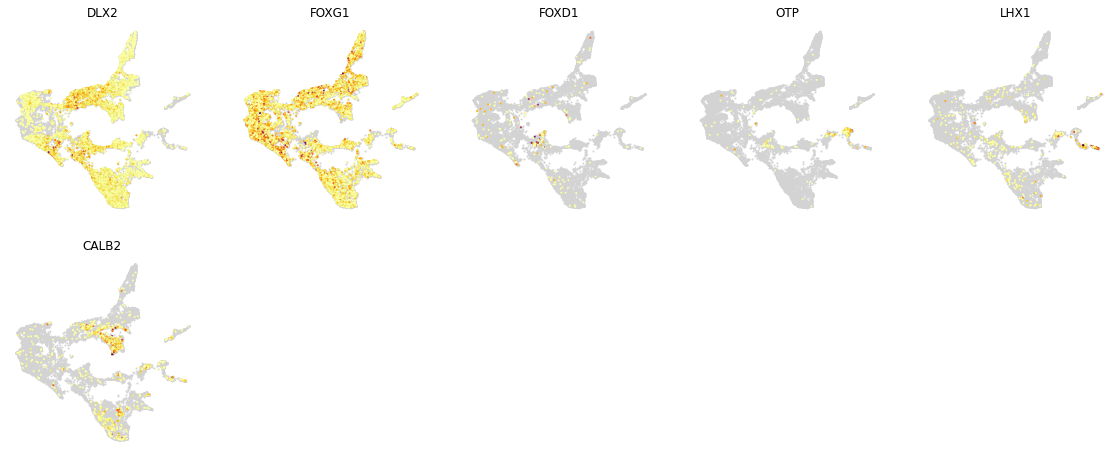

In [104]:
plot_markers(view8a,Thalamus_genes, height=2, width =5, file_name= 'Subpallium_8wk_Thalamus_genes2')

In [37]:
Thalamus_genes14 = ['FOXG1','FOXD1','SST','RBFOX3','CRABP1','SPARCL1']

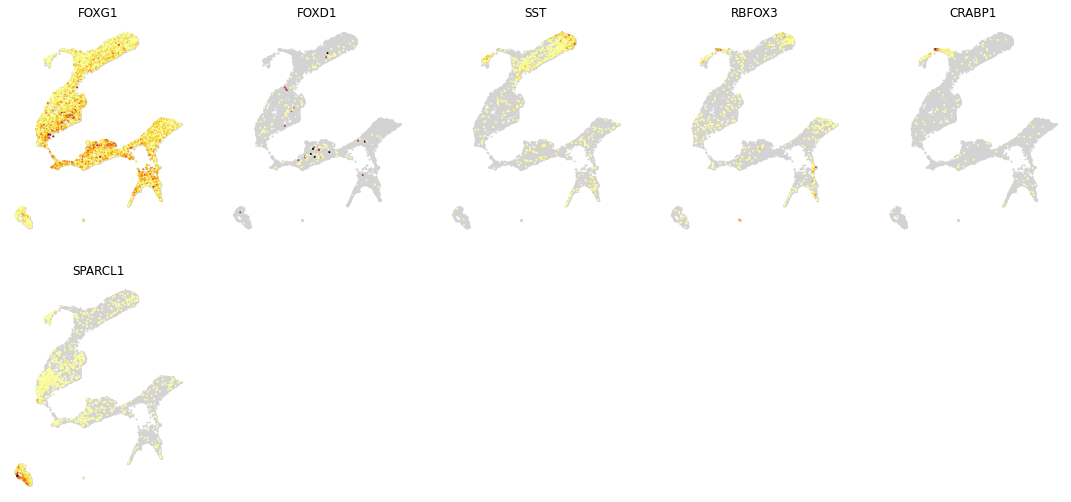

In [38]:

plot_markers(view14a,Thalamus_genes14, height=4, width =5, file_name= 'Subpallium_14wk_Thalamus_genes2')

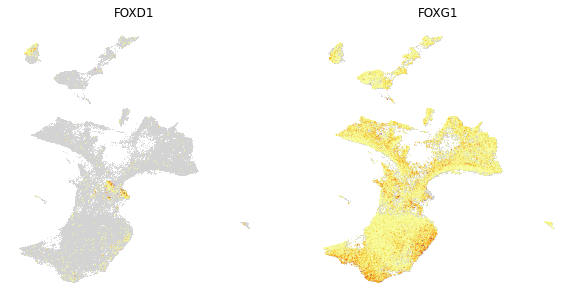

In [112]:
plot_markers(view,['FOXD1','FOXG1'], height=1, width =2, file_name= 'CleanPoolSubpallium6wk_FOXG1_FOXD1')